In [1]:
%load_ext autoreload
%autoreload 2

# Dataset explanation

For our project, we've selected a dataset constructed from internal email exchanges within a large European research institution. The dataset captures anonymized records of all emails sent between members of the institution. In the corresponding network, an edge
$(u,v)$ exists whenever person $u$ sent at least one email to person $v$. Because the data only includes communication among institutional members, it represents a closed network without any external incoming or outgoing messages.

An important feature of this dataset is the availability of “ground-truth” community labels. Each individual belongs to exactly one of the institution’s 42 departments, providing predefined community memberships that can be used to evaluate our community detection methods.

The dataset can be accessed from the following link (https://snap.stanford.edu/data/email-Eu-core.html), or downloaded and put inside the correct folder by executing the following cell.



In [2]:
from utils import download_data

files = [
    "email-Eu-core.txt.gz",
    "email-Eu-core-department-labels.txt.gz"
]

# download_data('twitch', "https://github.com/Carda01/community_detection/releases/download/1.0/", ['twitch_data.zip'], category='twitch')
# download_data('email', "https://snap.stanford.edu/data/", files, category='email')

Extracting PTBR files from twitch_data.zip...
Extracting twitch_data/musae_PTBR_target.csv...
Extracting twitch_data/musae_PTBR_edges.csv...
Twitch PTBR files downloaded and extracted successfully.
Extracting email-Eu-core.txt.gz...
Saved extracted file to data/email/email-Eu-core.txt

Extracting email-Eu-core-department-labels.txt.gz...
Saved extracted file to data/email/email-Eu-core-department-labels.txt

Email core files downloaded and extracted successfully.


# Preliminary analysis

For the following preliminary analysis we made the graph undirected, so as long as there is an edge between u and v (no matter the direction), in the newly built undirected graph there will be an edge between u and v. Also we've removed from the graph those nodes which have just self loops and no other edges to other nodes.


In [3]:
from utils import *

G = load_email()
show_mail_graph(G, k_core=5)

Calculating and adding node attribute 'degree'...


alt.LayerChart(...)

### Spy Plot

The sparsity plot (spyplot) of the adjacency matrix with the nodes ordered by their department is a sanity check.

If we get diagonal blocks it means that people inside their department sends each other a lot of mails, while they tend to send few to people of other departments.
And this is actually what we get. At the same time, there are some people (from departments 32-37 and especially department 36) who sends email to all the people. Our hypothesis is that they are the
managers or system admin department. We can already predict that it will be hard for these departments to separate them into their respective communities.
Additionally, we can notice that the communities vary drastically in size, and some are very small, like the 18th or the 12th.

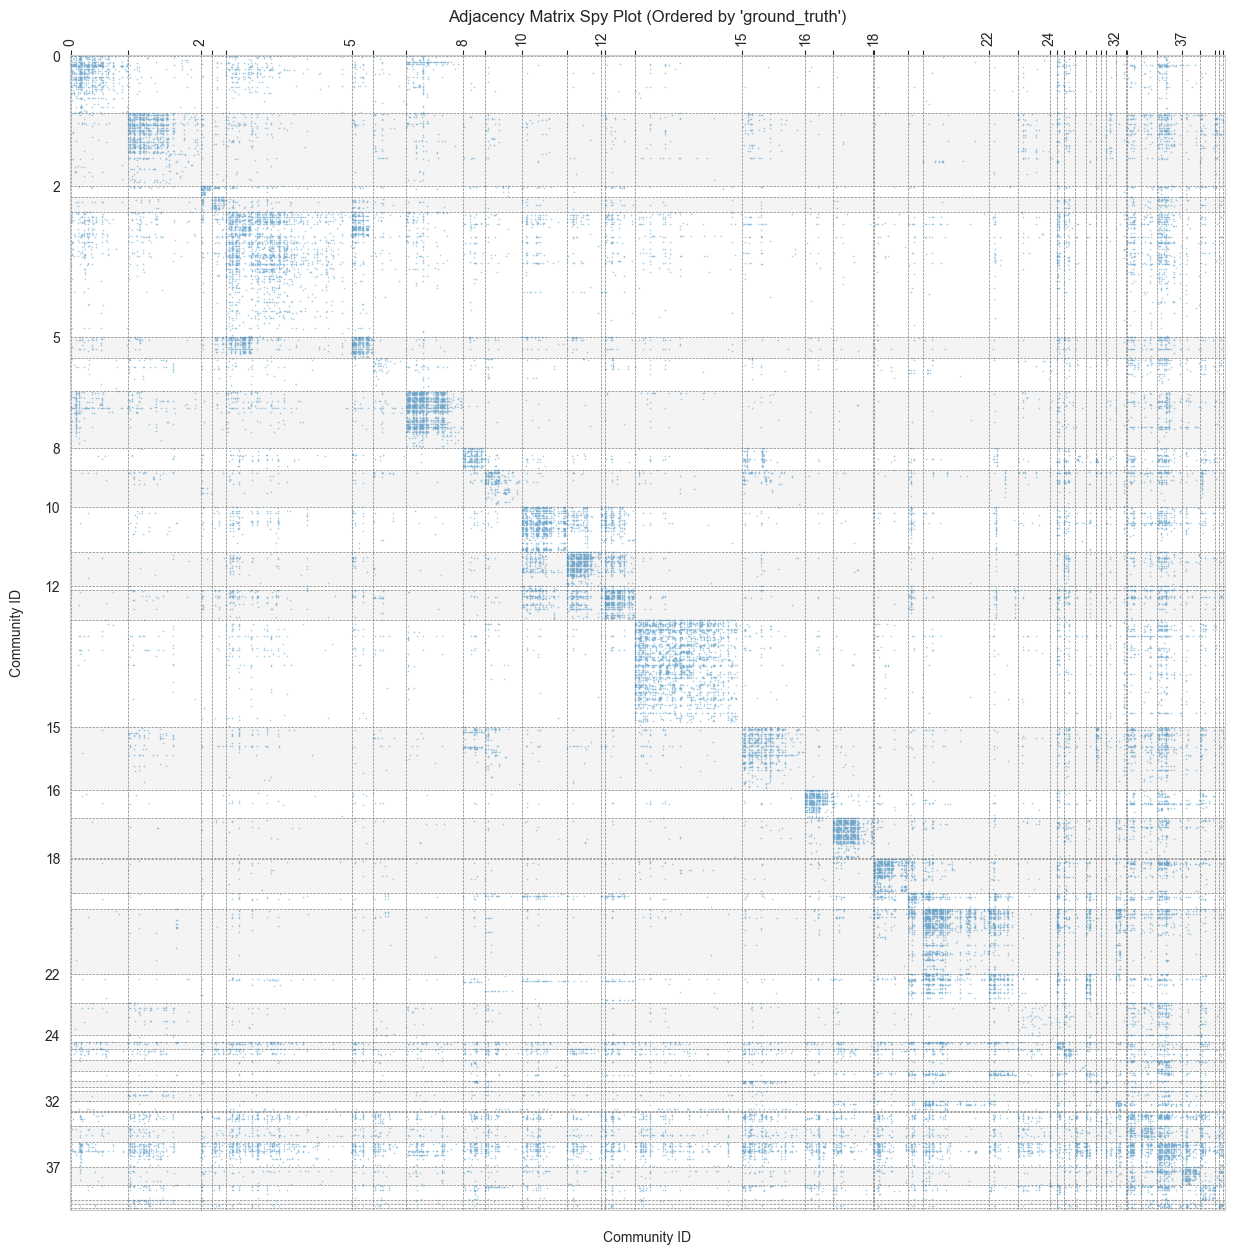

In [4]:
from utils import *

spy_plot_adjacency(G)

### General statistics
From the values of the diameter and the avg shortest path length, we can say that the network exhibits the classic "small-world" property. The degree distribution is
heavily right-skewed. It also indicates the presence of few highly connected nodes (hubs) whose degrees extend towards 350. The network's communication flow is largely
driven by these hubs (likely managers, system admins, or highly collaborative individuals), while the majority of nodes have lower connectivity.

The Clique Size (k) Distribution plot shows a roughly normal (bell-shaped) distribution centered around $k \approx 9$ to 10. This suggests a strong, consistent tendency
for nodes to organize into tightly connected, medium-sized groups (cliques). This is a strong indicator of robust community structure. Also, this can be noticed by the
high value of the clustering coefficient. In a random graph it is rougly equal to the density, but here we have $0.4 \gg 0.03$.


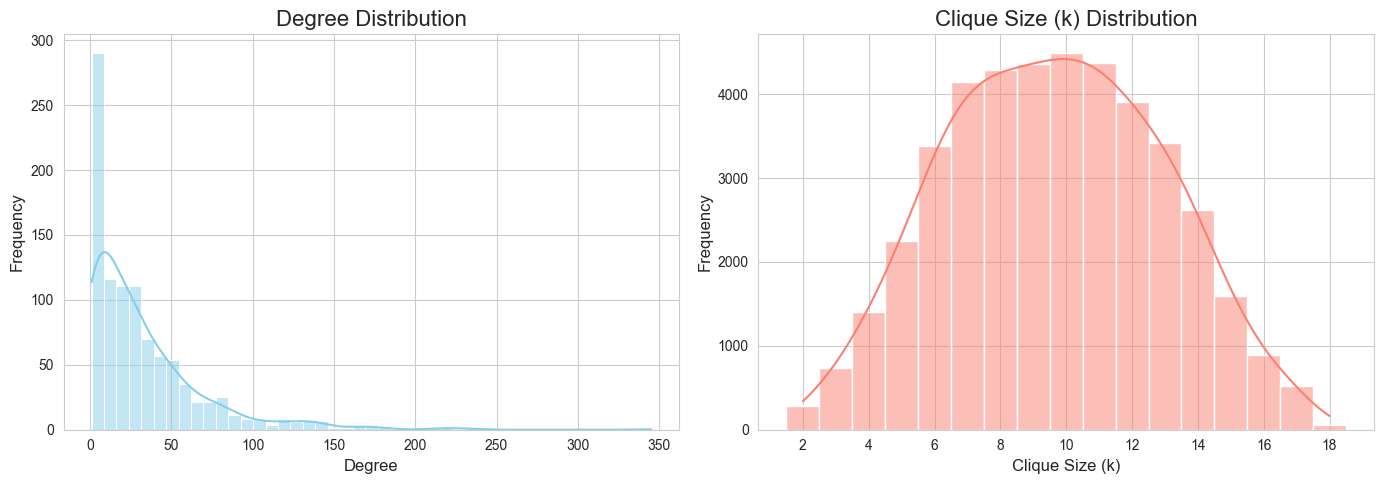

Number of nodes: 986
Number of edges: 16064
Average degree: 32.58
Density: 0.0331
Average clustering coefficient: 0.4071
Graph is connected.
Radius: 4
Diameter: 7
Average shortest path length: 2.59


In [5]:
hist_degrees_cliques(G)
summary_stats(G)

### Centrality Measures
bla bla bla fill this


In [6]:
import networkx as nx
from utils import *

centralities = calculate_centrality_metrics(G, [nx.pagerank, nx.betweenness_centrality, nx.closeness_centrality, nx.laplacian_centrality, nx.eigenvector_centrality])

Calculating and adding node attribute 'pagerank'...
Calculating and adding node attribute 'betweenness_centrality'...
Calculating and adding node attribute 'closeness_centrality'...
Calculating and adding node attribute 'laplacian_centrality'...
Calculating and adding node attribute 'eigenvector_centrality'...


In [7]:
show_top_nodes_by_centrality(centralities, 'betweenness_centrality')

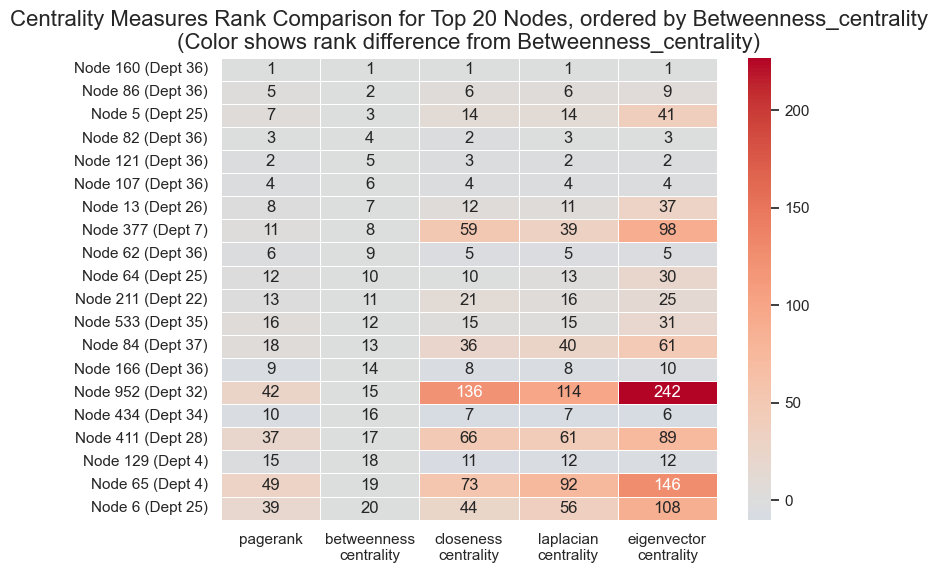

In [8]:
visualize_top_n_centrality(centralities, 'betweenness_centrality')

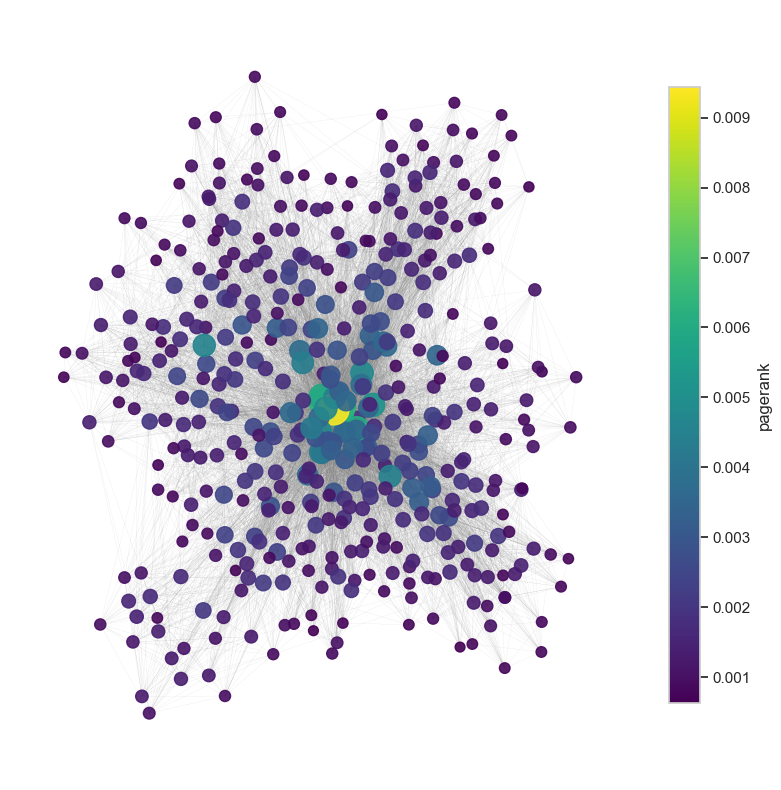

In [10]:
generic_show_static(G, node_color='betweenness_centrality',
             node_size='pagerank',
             k_core=20,
             layout_func=nx.spring_layout)


# Community detection
bla bla bla fill this


# Influence Maximization
We consider a scenario in which the EU research institution aims to identify internal security vulnerabilities.
If a malicious actor compromises a single user's email account, they can leverage established organizational trust to propagate malicious
content to colleagues in a cascading attack. Consequently, our objective is to identify the users who represent the highest risk,
specifically, those whose compromise would result in the widest dissemination of the threat. Formally, this is an Influence Maximization
problem, where we aim to identify the optimal seed set S that maximizes the spread of influence across the network.

In [11]:
from utils import *
G = load_email(directed=False)

### The algorithm
We adopted a probabilistic approach for modeling influence spread, specifically utilizing the Independent Cascade (IC) model
rather than the deterministic Threshold model.

Our hypothesis posits that an individual's decision to open a malicious email and follow links is inherently uncertain,
making it more accurately represented by a probability. In the IC model, when a node (person) becomes activated (infected),
it attempts to activate its neighbors with a certain probability p, which aligns better with this uncertainty.

One issue in this case, is that the spread function $\sigma$ is not deterministic as it was in the threshold model we saw in class.
This means we cannot inherently guarantee the submodularity property, which is crucial for proving the performance bound of the simple
Greedy algorithm.

To approximate a submodular spread function, we employ a Monte Carlo (MC) simulation approach. The spread is estimated by running the
influence propagation M times (controlled by the parameter MC_SIMULATIONS) and taking the mean of the results:

$\sigma(S) \approx \frac{1}{M}\Sigma_{i = 1}^{M} |Activated_i(S)|$

This averaging technique provides a good approximation of the true expected spread.

Additionally, as the process was quite slow, we've decide to parallelize the run of MC simulations,
so running our code in a laptop with many CPUs, can make the run incredibly fast.
Unfortunately we did not find a library that implemented influence maximization as we want it. So we've created it from scratch.

We've looked at SOTA methods to do influence maximization and we've found that CELF:

J. Leskovec, A. Krause, C. Guestrin, C. Faloutsos, J. VanBriesen, and N. S. Glance, "**Cost-Effective Outbreak Detection in Networks**," *Proceedings of the 21st International Conference on Neural Information Processing Systems (NIPS)*, 2007.

 was one of them. It is an optimization to the Greedy approach
we've looked at in class, that once it found the first node in the seed, it re-evaluates the marginal gain only for the top candidate
 and a few nodes that move up in the ranking, compared to the naive greedy algorithm that looks at all the other nodes again.
We've used this blog post as inspiration (https://hautahi.com/im_greedycelf), however we found different
logical errors in it and made some great improvements on it, (for example a node in this implementation could activate more than once,
if it was neighbour of two newly activated nodes).

At the end, we discovered that in our case the naive greedy worked better for us, as it was faster. The reason is that we've also parallelized
the function that get the spread of the seeds, so it finds the spread for multiple seeds at the same time.
The CELF optimization is inherently sequential. It must calculate the spread of the single top candidate, update the list, and repeat until convergence.
This sequential dependency limits the potential for substantial parallel speedup.
While brute forcing for all the possible seeds generated, by adding a node to the current seed,
can actually be parallelized, and in our case for our networks, runs faster. But if this code is run in machine with just a CPU,
then instead of using greedy, the function celf will probably achieve better performances. Both are implemented and can be used.

In [12]:
P_INFLUENCE = 0.05
MC_SIMULATIONS = 10
BUDGET = 5

seeds, final_spread = greedy(G, k=BUDGET, p=P_INFLUENCE, mc=MC_SIMULATIONS)
# seeds, final_spread = celf(G, k=BUDGET, p=P_INFLUENCE, mc=MC_SIMULATIONS)

print("-" * 50)
print(f"Optimal Seed Set S: {seeds}")
print(f"Estimated Total Spread: {final_spread:.2f} users, so {final_spread/G.number_of_nodes() * 100:.1f}% of the users")
print("-" * 50)


[Starting Greedy] Target seeds: 5 | Simulations: 10 | p: 0.05
  > Finding seed 1/5 (evaluating 986 nodes)...


  0%|          | 0/986 [00:00<?, ?it/s]

  > Seed 1 found: Node 426 (Marginal Gain: 550.00) | Total Spread: 550.00
  > Finding seed 2/5 (evaluating 985 nodes)...


  0%|          | 0/985 [00:00<?, ?it/s]

  > Seed 2 found: Node 506 (Marginal Gain: 3.80) | Total Spread: 553.80
  > Finding seed 3/5 (evaluating 984 nodes)...


  0%|          | 0/984 [00:00<?, ?it/s]

  > No further node could improve the spread.
--------------------------------------------------
Optimal Seed Set S: [426, 506]
Estimated Total Spread: 553.80 users, so 56.2% of the users
--------------------------------------------------


In [13]:
from utils import *
G_infected = simulate_and_tag_infection(G, seeds, p=P_INFLUENCE)

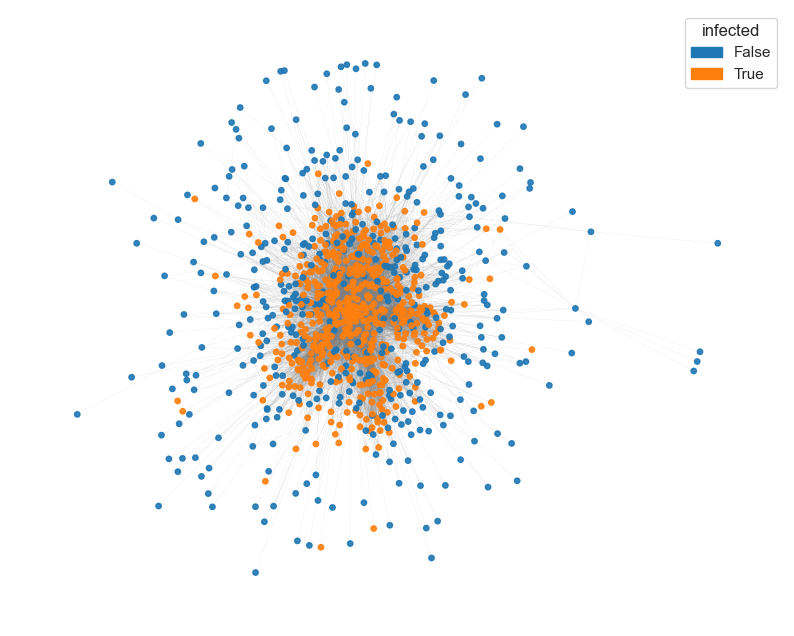

Percentage of infected nodes 55.4%


In [14]:
generic_show_static(G_infected, node_color='infected', node_size=15, k_core=0, width=10, height=8)
infected_count = sum(1 for node, data in G_infected.nodes(data=True) if data.get('infected') is True)
infected_percentage = infected_count / G_infected.number_of_nodes() * 100
print(f"Percentage of infected nodes {infected_percentage:.1f}%")